## Remarks

The basic data preprocessing structure was derived by: [1] http://analyticmunch.weebly.com/semeval-2010-task-8.html

In [1]:
# Imports

import re
import csv
import pandas as pd
import numpy as np
import random
import pickle
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.pipeline import Pipeline
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV
import nltk
from nltk import word_tokenize

## Reading in and cleaning data

In [2]:
# Input File Paths
training_data = 'data/training/TRAIN_FILE.TXT'
test_data_sentences = 'data/test/TEST_FILE_CLEAN.TXT'
test_data_keys = 'data/test/TEST_FILE_KEY.TXT'

# Output File Paths
training_data_cleaned = 'train_data.csv'
test_data_sentences_cleaned = 'test_data_sentences.csv'
test_data_keys_cleaned = 'test_data_keys.csv'
naive_bayes_predictions = 'naive_bayes_predictions.csv'

In [3]:
# Configuration for Testing
binary_category = 'Entity-Destination'
pos_tagging = False

In [4]:
# Reference: [1]

def read_data_by_line(input_data):
    all_lines = []
    with open(input_data, 'r') as file:
        temp_lines = file.readlines()
        for line in temp_lines:
            line = line.strip()
            if line:
                all_lines.append(line)
    return all_lines

def load_data(input_data, is_training_data):
    data_lines = read_data_by_line(input_data)
    data_raw = []
    i = 0
    for line in data_lines:
        # remove 'Comment' line for training data
        if is_training_data:
            if not line.startswith('Comment:'):
                data_raw.append(line.split('|'))
        else:
            data_raw.append(line.split('|'))
        i += 1

    sentences = []
    relations = []

    for i,j in enumerate(data_raw, 1):
        if is_training_data:
            if i%2 == 0:
                relations.append(j)
            else:
                sentences.append(j)
        else:
            sentences.append(j)
            
    e1e2 = []
    for sentence_line in sentences:
        sentence_string = ''.join(sentence_line)
        sentence_match = re.sub('\t','',sentence_string)
        k=sentence_match.lstrip('0123456789.-')
        sentence_sub = re.sub('<[^>]*>', '', k)
        sentence_line_final = sentence_sub.replace('"', '')
        e1e2.append(sentence_line_final)

    # converting to strings
    relations_string = ','.join(str(r) for v in relations for r in v)
    w2 = re.sub(r'\([^)]*\)', "",relations_string).split(',')
    
    # Generating sentence-relation tuples for the csv
    data_output = zip(e1e2,w2)
    
    if is_training_data:
        with open(training_data_cleaned, "w") as train_file:
            writer = csv.writer(train_file,delimiter=',')
            for row in data_output:
                writer.writerow(row)
    else:   
        with open(test_data_sentences_cleaned, "w") as test_sentences_file:
            writer = csv.writer(test_sentences_file)
            for row in e1e2:
                writer.writerow([row])
                
def load_keys_data(input_data):
        with open(input_data, 'r') as file:
            key_value = []
            key_lines = file.readlines()
            
            for line in key_lines:
                key_line = line.strip()
                key_string = ''.join(key_line)
                key_match = re.sub('\t \r \n','',key_string)
                key_rem_num = key_match.lstrip('0123456789.-')
                key_rem_num = re.sub('\t','',key_rem_num)
                key_value.append(key_rem_num)
                
            with open(test_data_keys_cleaned, "w") as test_keys_file:
                writer_key = csv.writer(test_keys_file,delimiter=',')
                for row_key in key_value:
                    writer_key.writerow([row_key])                

In [5]:
load_data(training_data, True)
load_data(test_data_sentences, False)
load_keys_data(test_data_keys)

## Preparing Data

In [6]:
# Reference: [1]

# Reading cleaned training data
train_col_names = ['Sentence','Relation']
train_data = pd.read_csv(training_data_cleaned, header = None, names = train_col_names)
train_data = pd.DataFrame(train_data)
train_data_str = train_data['Sentence'].astype(str)

train_data_relation = train_data[['Relation']]

# Reading cleaned test data (sentences)
test_col_names = ['Sentence']
test_data = pd.read_csv(test_data_sentences_cleaned, header = None, names = test_col_names)
test_data = pd.DataFrame(test_data)
test_data_str = test_data['Sentence'].astype(str)

# Reading cleaned test data (keys)
test_keys = pd.read_csv(test_data_keys_cleaned, header = None)

In [7]:
# Overwrite every category with 'other' except 'Entity-Destination'
test_keys['category'] = 'Other'
test_keys['category'][test_keys[0]==binary_category] = binary_category
test_keys

,0,category
0,Message-Topic,Other
1,Product-Producer,Other
2,Instrument-Agency,Other
3,Entity-Destination,Entity-Destination
4,Cause-Effect,Other
...,...,...
2712,Instrument-Agency,Other
2713,Product-Producer,Other
2714,Component-Whole,Other
2715,Product-Producer,Other


In [8]:
# Reference: [1]

def factorize_relation_old(x):
    if x=='Other':
        return 0
    if x=='Cause-Effect':
        return 1
    if x=='Product-Producer':
        return 2
    if x=='Entity-Origin':
        return 3
    if x=='Instrument-Agency':
        return 4
    if x=='Component-Whole':
        return 5
    if x=='Content-Container':
        return 6
    if x=='Entity-Destination':
        return 7
    if x=='Member-Collection':
        return 8
    if x=='Message-Topic':
        return 9
    
def factorize_relation(x):
    if x==binary_category:
        return 1
    else:
        return 0

# Factorizing train relations    
train_data_relation['Relation_Number'] = train_data_relation['Relation'].apply(factorize_relation)
train_data_relation_array = np.array(train_data_relation['Relation_Number'])

# Factorizing test keys
test_keys['Relation_Number'] = test_keys[0].apply(factorize_relation)
test_keys_array = np.array(test_keys['Relation_Number'])

### POS-tagging the sentences 

In [9]:
if pos_tagging:
    wpt = nltk.WordPunctTokenizer()

    pos_tagged_train_sentences = []
    pos_tagged_test_sentences = []

    for sentence in train_data_str:
        text = wpt.tokenize(sentence[:-1])
        text_tagged = nltk.pos_tag(text)
        new_text = []
        for word in text_tagged:
            new_text.append(word[0] + "/" + word[1])

        doc = ' '.join(new_text)
        pos_tagged_train_sentences.append(str(doc))

    train_data_str = pos_tagged_train_sentences
    print(pos_tagged_train_sentences[0])
    for sentence in test_data_str:
        text = wpt.tokenize(sentence[:-1])
        text_tagged = nltk.pos_tag(text)
        new_text = []
        for word in text_tagged:
            new_text.append(word[0] + "/" + word[1])

        doc = ' '.join(new_text)
        pos_tagged_test_sentences.append(str(doc))
    
    test_data_str = pos_tagged_test_sentences

## Building Baseline Model: Naive Bayes

In [11]:
# Preprocess data using pipeline
classifier = MultinomialNB(alpha=0.01)
text_classification = Pipeline([('vectorizer', CountVectorizer(ngram_range=(1,3))), ('tfidftransformer', TfidfTransformer(use_idf=True)), ('classification', classifier)])

# Train model
text_classification = text_classification.fit(train_data_str, train_data_relation_array)

# Make predictions
predictions = text_classification.predict(test_data_str)

# Save Predictions to csv file
np.savetxt(naive_bayes_predictions, predictions, delimiter=",")

# Compute accuracy
accuracy_for_test_keys = np.mean(predictions == test_keys_array)
print("Multinomial Naive Bayes Model, Accuracy = {} %".format(accuracy_for_test_keys * 100))

Multinomial Naive Bayes Model, Accuracy = 94.70003680529996 %


In [12]:
# save the model to disk.
filename = 'baseline_classifier.sav'
pickle.dump(text_classification, open(filename, 'wb'))
# load the model from disk.
loaded_model = pickle.load(open(filename, 'rb'))
# result = loaded_model.score(X_test, Y_test)
loaded_model.predict(test_data_str)

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [13]:
def unfactorize_relation_old(x):
    if x==0:
        return 'Other'
    if x==1:
        return 'Cause-Effect'
    if x==2:
        return 'Product-Producer'
    if x==3:
        return 'Entity-Origin'
    if x==4:
        return 'Instrument-Agency'
    if x==5:
        return 'Component-Whole'
    if x==6:
        return 'Content-Container'
    if x==7:
        return 'Entity-Destination'
    if x==8:
        return 'Member-Collection'
    if x==9:
        return 'Message-Topic'
    
def unfactorize_relation(x):
    if x==0:
        return 'Other'
    if x==1:
        return binary_category   

evaluation_table = pd.DataFrame()
evaluation_table["Sentence"] = test_data_str
evaluation_table["True Category"] = test_keys['category']
evaluation_table["Predicted Category"] = predictions
evaluation_table["Predicted Category"] = evaluation_table["Predicted Category"].apply(unfactorize_relation)
evaluation_table["Prediction Correct"] = True
evaluation_table.loc[evaluation_table["Predicted Category"] != evaluation_table["True Category"], 'Prediction Correct'] = False
evaluation_table

,Sentence,True Category,Predicted Category,Prediction Correct
0,The most common audits were about waste and re...,Other,Other,True
1,The company fabricates plastic chairs.,Other,Other,True
2,The school master teaches the lesson with a st...,Other,Other,True
3,The suspect dumped the dead body into a local ...,Entity-Destination,Entity-Destination,True
4,Avian influenza is an infectious disease of bi...,Other,Other,True
...,...,...,...,...
2712,"After seating all the idols, which itself take...",Other,Other,True
2713,The minister attributed the slow production of...,Other,Other,True
2714,The umbrella frame is provided with a movable ...,Other,Other,True
2715,Manos: The Hands of Fate is a low-budget horro...,Other,Other,True


In [14]:
evaluation_table["Predicted Category"].unique()

array(['Other', 'Entity-Destination'], dtype=object)

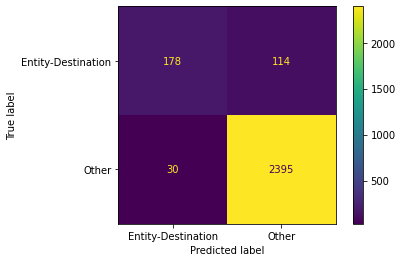

In [15]:
ConfusionMatrixDisplay.from_predictions(evaluation_table["True Category"], evaluation_table["Predicted Category"])

In [16]:
evaluation_table['Prediction Correct'].value_counts()

True     2573
False     144
Name: Prediction Correct, dtype: int64

In [17]:
wrong_predictions = evaluation_table[evaluation_table['Prediction Correct']==False]['True Category']
wrong_predictions.value_counts()

Entity-Destination    114
Other                  30
Name: True Category, dtype: int64

## Inspecting the wrong predictions more closely

In [18]:
# wrong_predictions['Other']
wrongly_predicted_others = wrong_predictions.loc[lambda x : x == 'Other']
wrongly_predicted_relation = wrong_predictions.loc[lambda x : x == binary_category]
wrongly_predicted_others_indices = list(wrongly_predicted_others.index)
wrongly_predicted_relation_indices = list(wrongly_predicted_relation.index)

In [19]:
## get false positive sentences of the two categories

# model predicts '[chosen-relation]' but is wrong
false_positive_relation = test_data_str[wrongly_predicted_others_indices]
# model predicts 'other' but is wrong
false_positive_other = test_data_str[wrongly_predicted_relation_indices]

In [20]:
false_positive_relation

74      International ship sewage regulations have ent...
383     My aunt has been put into care suffering with ...
567     Two seniors in this house have arrived into se...
617     The new phone has been moved into prototype st...
717     The estranged couple transferred funds into th...
791     The commander has dragged soldiers into unnece...
917     At my work, an electronic engineer has migrate...
941                   Eight busloads ran into contention.
966     Another 40 million people have been pushed int...
1095    The man dug a three-foot-deep fire pit to roas...
1169    These initiations only have been passed on to ...
1244           You have poured balm into my anxious soul.
1245                  The cops took the man into custody.
1273    The letter was sent from group to group of the...
1278    The boat basically sails from the harbour to a...
1282    My room has been moved into the corner of the ...
1438    The bottle carrier converts your bottle into a...
1470    The al